# Why overfitting does not conflict with CLT bounds 

In [104]:
import numpy as np
import pandas as pd

from pandas import melt
from pandas import DataFrame

from numpy.random import choice
from numpy.random import uniform
from scipy.stats import binom

from plotnine import *

## I. Example  setup

Let us consider the data source with unpredictable target value. 

In [24]:
def data_gen(n: int):
    return DataFrame({'x': uniform(size=n), 'y': choice([0,1], size=n, replace=True) })    

Let $f_0$ and $f_1$ will be constant predictors defined as follows.

In [25]:
def f0(x):
    return [0] * len(x)

def f1(x):
    return [1] * len(x)

Let the empirical risk $R_n(f)$ be defined as follows.

In [27]:
def empirical_risk(data, f):
    yhat = f(data)
    return np.mean(yhat != data['y'])

## II. How sampling bounds are satisfied for different training sets

If the training set contains $n$ elements then it is straightforward to compute 95% confidence intervals for the empirical risks of $R_n(f)$ for $f_0$ and $f_1$. As the label $y$ is independent form the input $\boldsymbol{x}$, we can compute these bounds from using the quantiles of Bernulli distribution.  

In [86]:
def probability_interval(n: int, prob: float = 0.95):
    return [binom.ppf(0.5 * (1 - prob), n=n, p=0.5)/n, binom.ppf(1 - 0.5 * (1 - prob), n=n, p=0.5)/n] 

Now we can do the experiment and collect the estimates of empirical risks for training set of size 100.

In [177]:
n = 100
k = 100
y_0, y_1 = probability_interval(n)

emp_risk = DataFrame(None, index=range(10), columns=['$f_0$', '$f_1$', 'winner'])

for i in range(k):
    data = data_gen(n)
    emp_risk.loc[i, '$f_0$'] = empirical_risk(data, f0)
    emp_risk.loc[i, '$f_1$'] = empirical_risk(data, f1)
    emp_risk.loc[i, 'winner'] = '$f_0$' if emp_risk.loc[i, '$f_0$'] < emp_risk.loc[i, '$f_1$'] else '$f_1$' 

In [178]:
sdf = melt(emp_risk, id_vars=['winner'], var_name='function', value_name='emp_risk')
sdf['emp_risk'] = sdf['emp_risk'].astype(float)

sdf['type'] = 'Good approximator'
sdf.loc[sdf['emp_risk'] <= y_0, 'type'] = 'Lower outlier'
sdf.loc[sdf['emp_risk'] >= y_1, 'type'] = 'Upper outlier'
sdf['winner'] = sdf['winner'] == sdf['function']

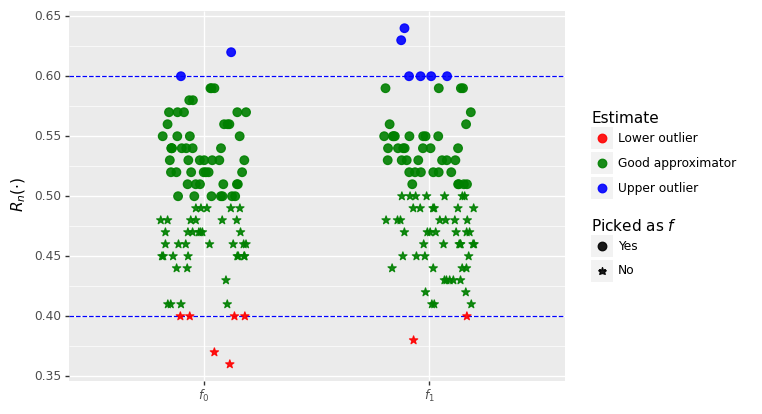

<ggplot: (708855025)>

In [190]:
p  = ggplot(sdf)
p += geom_hline(yintercept=y_0, linetype='dashed', color='blue')
p += geom_hline(yintercept=y_1, linetype='dashed', color='blue')
p += geom_jitter(aes(x='function', y='emp_risk', color='type', shape='winner'), 
                 size=3, width=0.2, height=0, alpha=0.9) 
p += scale_color_manual(
    name = 'Estimate',
    values=['red', 'green', 'blue'], 
    breaks=['Lower outlier', 'Good approximator', 'Upper outlier']) 
p += scale_shape_manual(
    name = 'Picked as $f$',
    values = ['o', '*'],
    breaks = [False, True],
    labels = ['Yes', 'No']
)
p += xlab('') + ylab('$R_n(\cdot)$')
display(p)
p.save('empirical_risk_and_learning.pdf', verbose=False)